# My Beats

Process all tempogram `.npy` from `data/derived/tempogram`, run Ellis DP beat tracking using matched novelty files, compute meter (beats-per-bar and bar/beat labels) for tracks with HEAD_IN markers, and save beat times to `data/derived/beats` and meter labels to `data/derived/meter`.

In [1]:
import json
import sys
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import numpy as np

project_root = Path.cwd()
if not (project_root / "src" / "dijon").exists():
    project_root = project_root.parent
sys.path.insert(0, str(project_root))

from dijon.beats import (
    compute_beat_sequence,
    estimate_beats_per_bar,
    label_bars_and_beats,
)
from dijon.global_config import AUDIO_MARKERS_DIR, DERIVED_DIR, RAW_AUDIO_DIR

%matplotlib inline

In [2]:
FS_NOV = 100.0
THETA = np.arange(40, 321, dtype=np.float64)
FACTOR = 1.0

NOVELTY_DIR = DERIVED_DIR / "novelty"
TEMPOGRAM_DIR = DERIVED_DIR / "tempogram"
BEATS_OUTPUT_DIR = DERIVED_DIR / "beats"
METER_OUTPUT_DIR = DERIVED_DIR / "meter"

OVERRIDE_FILES = []  # set to [Path("path/to/file.npy")] to process specific tempogram(s)


def _get_head_in_time_sec(track_name: str) -> float | None:
    """Load HEAD_IN_START position from marker JSON. Returns None if missing."""
    marker_path = AUDIO_MARKERS_DIR / f"{track_name}_markers.json"
    if not marker_path.exists():
        return None
    try:
        with open(marker_path, encoding="utf-8") as f:
            payload = json.load(f)
        if "entries" in payload and payload["entries"]:
            markers = payload["entries"][0].get("markers", [])
        elif "markers" in payload:
            markers = payload["markers"]
        else:
            return None
        for m in markers:
            if isinstance(m, dict) and m.get("name") == "HEAD_IN_START" and "position" in m:
                return float(m["position"])
    except (json.JSONDecodeError, KeyError, TypeError):
        pass
    return None


def _track_name_from_tempogram_stem(stem: str) -> str:
    if "_tempogram_" in stem:
        return stem.split("_tempogram_")[0]
    return stem


def _find_novelty_for_track(track_name: str, novelty_dir: Path) -> Path | None:
    prefix = f"{track_name}_novelty_"
    matches = sorted(novelty_dir.glob(f"{prefix}*.npy"))
    return matches[0] if matches else None


if OVERRIDE_FILES:
    tempogram_paths = [Path(p).resolve() for p in OVERRIDE_FILES]
else:
    tempogram_paths = sorted(TEMPOGRAM_DIR.glob("*.npy")) if TEMPOGRAM_DIR.exists() else []

items = []
for tempo_path in tempogram_paths:
    track_name = _track_name_from_tempogram_stem(tempo_path.stem)
    nov_path = _find_novelty_for_track(track_name, NOVELTY_DIR)
    if nov_path is None:
        print(f"Skip {track_name}: no matching novelty in {NOVELTY_DIR}")
        continue
    items.append((track_name, nov_path, tempo_path))

print(f"Found {len(items)} track(s) to process")
for track_name, nov_path, tempo_path in items:
    print(f"  {track_name}: novelty={nov_path.name} tempogram={tempo_path.name}")

Found 13 track(s) to process
  YTB-001: novelty=YTB-001_novelty_spectrum_1024-256-100.0-10.npy tempogram=YTB-001_tempogram_fourier_500-1-40-320.npy
  YTB-002: novelty=YTB-002_novelty_spectrum_1024-256-100.0-10.npy tempogram=YTB-002_tempogram_fourier_500-1-40-320.npy
  YTB-003: novelty=YTB-003_novelty_spectrum_1024-256-100.0-10.npy tempogram=YTB-003_tempogram_fourier_500-1-40-320.npy
  YTB-004: novelty=YTB-004_novelty_spectrum_1024-256-100.0-10.npy tempogram=YTB-004_tempogram_fourier_500-1-40-320.npy
  YTB-005: novelty=YTB-005_novelty_spectrum_1024-256-100.0-10.npy tempogram=YTB-005_tempogram_fourier_500-1-40-320.npy
  YTB-006: novelty=YTB-006_novelty_spectrum_1024-256-100.0-10.npy tempogram=YTB-006_tempogram_fourier_500-1-40-320.npy
  YTB-007: novelty=YTB-007_novelty_spectrum_1024-256-100.0-10.npy tempogram=YTB-007_tempogram_fourier_500-1-40-320.npy
  YTB-008: novelty=YTB-008_novelty_spectrum_1024-256-100.0-10.npy tempogram=YTB-008_tempogram_fourier_500-1-40-320.npy
  YTB-009: novelty=

In [3]:
beat_results = {}

for track_name, nov_path, tempo_path in items:
    novelty = np.load(nov_path).astype(np.float64)
    tempogram_arr = np.load(tempo_path)
    if tempogram_arr.ndim != 2:
        print(f"Skip {track_name}: tempogram shape {tempogram_arr.shape} not 2D")
        continue

    K, M = tempogram_arr.shape
    F_coef_BPM = THETA if K == len(THETA) else np.arange(40, 40 + K, dtype=np.float64)
    tempo_profile = np.mean(np.abs(tempogram_arr), axis=1)
    tempo_bpm = float(F_coef_BPM[int(np.argmax(tempo_profile))])
    beat_ref = int(np.round(FS_NOV * 60.0 / tempo_bpm))

    B = compute_beat_sequence(novelty, beat_ref=beat_ref, factor=FACTOR)
    beat_times = B / FS_NOV

    beat_results[track_name] = {
        "novelty": novelty,
        "beat_times": beat_times,
        "tempo_bpm": tempo_bpm,
        "beat_ref": beat_ref,
    }

    head_in = _get_head_in_time_sec(track_name)
    if head_in is None:
        print(f"  {track_name}: skip meter (no HEAD_IN_START marker)")
    else:
        audio_path = RAW_AUDIO_DIR / f"{track_name}.wav"
        if not audio_path.exists():
            print(f"  {track_name}: skip meter (audio not found: {audio_path})")
        else:
            x, sr = librosa.load(audio_path, sr=None, mono=True)
            beats_per_bar, low_energy, high_energy = estimate_beats_per_bar(
                beat_times, head_in, x, sr
            )
            labels = label_bars_and_beats(beat_times, head_in, beats_per_bar)
            beat_results[track_name]["labels"] = labels

    median_ibi = np.median(np.diff(beat_times)) if len(beat_times) > 1 else np.nan
    print(f"{track_name}: tempo={tempo_bpm:.1f} BPM | beats={len(B)} | median IBI={median_ibi:.3f}s")

YTB-001: tempo=206.0 BPM | beats=819 | median IBI=0.290s
YTB-002: tempo=292.0 BPM | beats=1226 | median IBI=0.210s
YTB-003: tempo=283.0 BPM | beats=992 | median IBI=0.210s
YTB-004: tempo=320.0 BPM | beats=327 | median IBI=0.190s
YTB-005: tempo=244.0 BPM | beats=702 | median IBI=0.250s
YTB-006: tempo=235.0 BPM | beats=1002 | median IBI=0.260s
YTB-007: tempo=255.0 BPM | beats=610 | median IBI=0.240s
YTB-008: tempo=196.0 BPM | beats=494 | median IBI=0.310s
YTB-009: tempo=206.0 BPM | beats=816 | median IBI=0.290s
YTB-011: tempo=269.0 BPM | beats=885 | median IBI=0.220s
YTB-012: tempo=228.0 BPM | beats=964 | median IBI=0.260s
YTB-013: tempo=253.0 BPM | beats=720 | median IBI=0.240s
YTB-014: tempo=228.0 BPM | beats=809 | median IBI=0.260s


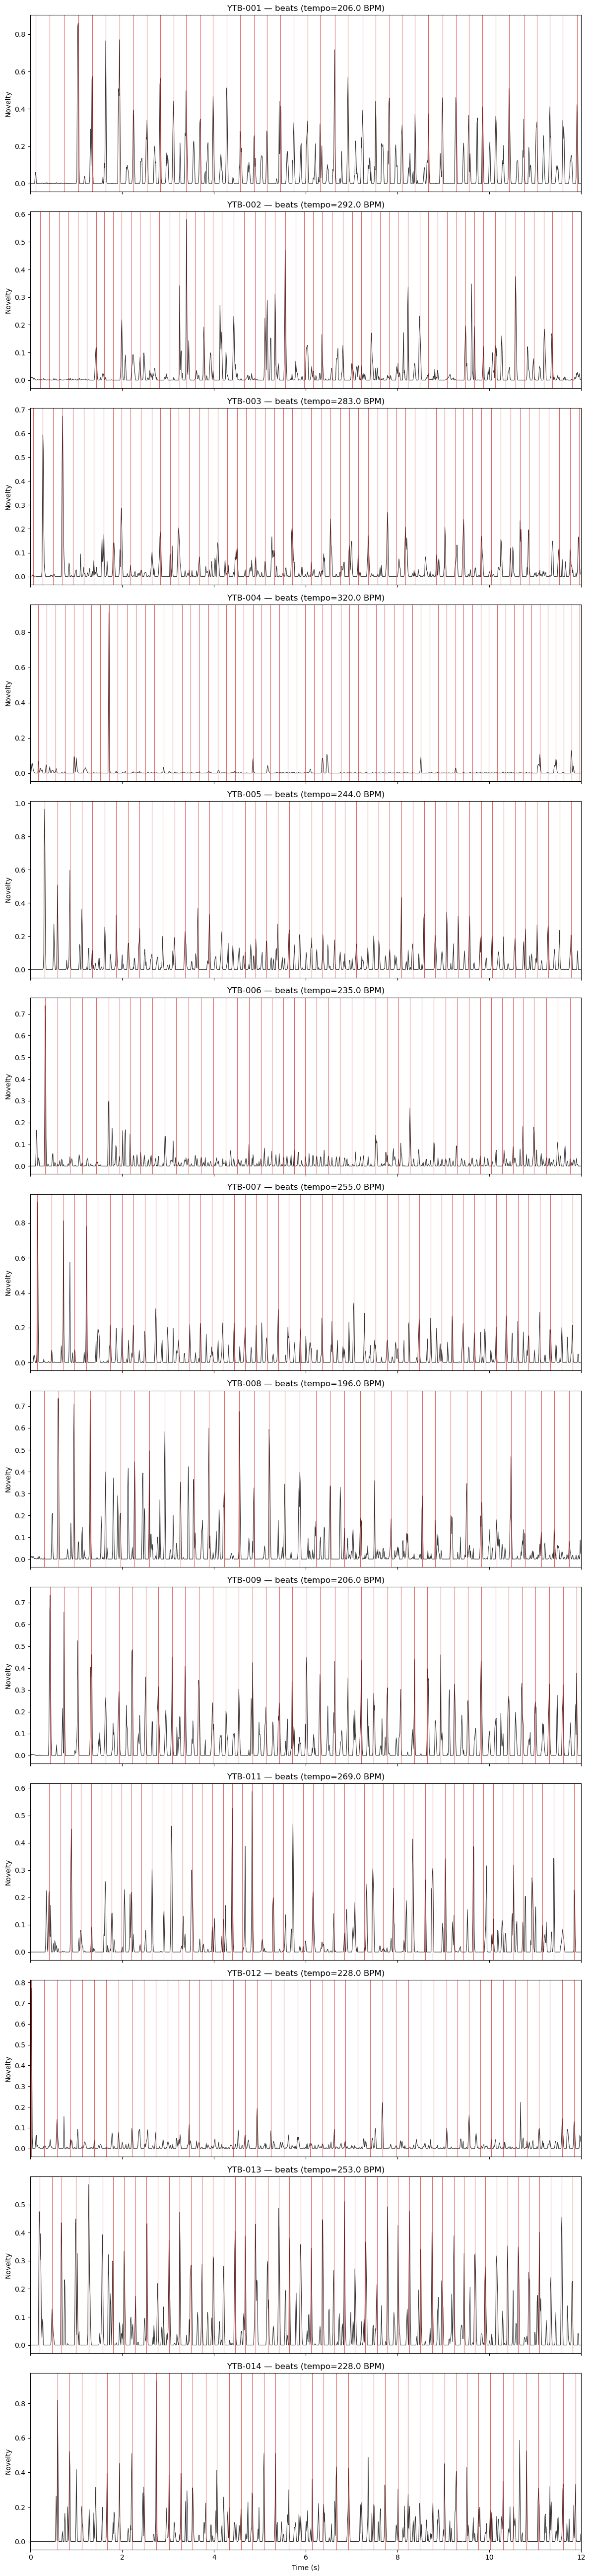

In [4]:
DISPLAY_SEC = 12

n_tracks = len(beat_results)
if n_tracks == 0:
    print("No results to plot")
else:
    fig, axes = plt.subplots(n_tracks, 1, figsize=(12, 4 * n_tracks), sharex=True)
    if n_tracks == 1:
        axes = [axes]
    for i, (track_name, data) in enumerate(beat_results.items()):
        nov = data["novelty"]
        beat_times = data["beat_times"]
        t_nov = np.arange(len(nov)) / FS_NOV
        n_frames = int(DISPLAY_SEC * FS_NOV)
        nov_vis = nov[: min(len(nov), n_frames)]
        t_vis = t_nov[: len(nov_vis)]
        axes[i].plot(t_vis, nov_vis, color="#333", linewidth=0.8)
        for beat in beat_times:
            if beat <= DISPLAY_SEC:
                axes[i].axvline(beat, color="#c00", alpha=0.6, linewidth=0.8)
        axes[i].set_ylabel("Novelty")
        axes[i].set_title(f"{track_name} — beats (tempo={data['tempo_bpm']:.1f} BPM)")
        axes[i].set_xlim(0, DISPLAY_SEC)
    axes[-1].set_xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

In [5]:
BEATS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

for track_name, data in beat_results.items():
    beat_times = data["beat_times"]
    out_path = BEATS_OUTPUT_DIR / f"{track_name}_beats.npy"
    np.save(out_path, beat_times, allow_pickle=False)
    print(f"Wrote {out_path}")

Wrote /Users/petermynett/dev/active/dijon/data/derived/beats/YTB-001_beats.npy
Wrote /Users/petermynett/dev/active/dijon/data/derived/beats/YTB-002_beats.npy
Wrote /Users/petermynett/dev/active/dijon/data/derived/beats/YTB-003_beats.npy
Wrote /Users/petermynett/dev/active/dijon/data/derived/beats/YTB-004_beats.npy
Wrote /Users/petermynett/dev/active/dijon/data/derived/beats/YTB-005_beats.npy
Wrote /Users/petermynett/dev/active/dijon/data/derived/beats/YTB-006_beats.npy
Wrote /Users/petermynett/dev/active/dijon/data/derived/beats/YTB-007_beats.npy
Wrote /Users/petermynett/dev/active/dijon/data/derived/beats/YTB-008_beats.npy
Wrote /Users/petermynett/dev/active/dijon/data/derived/beats/YTB-009_beats.npy
Wrote /Users/petermynett/dev/active/dijon/data/derived/beats/YTB-011_beats.npy
Wrote /Users/petermynett/dev/active/dijon/data/derived/beats/YTB-012_beats.npy
Wrote /Users/petermynett/dev/active/dijon/data/derived/beats/YTB-013_beats.npy
Wrote /Users/petermynett/dev/active/dijon/data/deriv

In [ ]:
METER_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

for track_name, data in beat_results.items():
    if "labels" not in data:
        continue
    labels = data["labels"]
    out_path = METER_OUTPUT_DIR / f"{track_name}_meter.npy"
    np.save(out_path, labels, allow_pickle=False)
    print(f"Wrote {out_path}")